### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- [Modeling](./03_modeling.ipynb)
- Experiments (this notebook)
- [Results and Recommendations](./04_results.ipynb)

**In this notebook, you'll find:**
- An informal experiment incorporating NLP of criminal charges as potentially predictive for the FL dataset
- An informal experiment using an important-feature-focused model to predict on the GA dataset
- Neither of these models are under consideration for production use based on their outcomes, but were worthwhile to explore

In [117]:
# standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# models for FL NLP
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# additional models for GA feature importance testing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

# metrics
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, f1_score, precision_score, confusion_matrix

# global random seed
np.random.seed(42)

In [118]:
# same function used in modeling notebook for evaluation
# Dataframe to collect results
model_trials_df = pd.DataFrame(columns=['dataset_name', 'model_used', 'model_params', 'train_score', 'test_score',
'accuracy', 'specificity', 'precision', 'recall', 'f1 score', 'true_neg', 'false_pos', 'false_neg', 'true_pos'])

def model_trials(dataset_name, X, y, model, model_id, scale_first = False, gs_params = None):
    '''
    Takes in dataset information and a (non-neural-net) model, fits the model, and appends fit metrics to a previously
    established Dataframe for later comparison. Also displays confusion matrix upon completion.

    Parameters:
    - dataset_name (string): used to differentiate between the NY/FL/GA models
    - X (Dataframe): features dataframe for all observations
    - y (Dataframe or Series): target classes for all observations:
    - model (classification model): non-neural-net model to fit
    - model_id (string): friendly name for model to include in results
    - scale_first (boolean): indicates whether the feature set X should be scaled before fitting
    - gs_params (dict): parameters for a GridSearch - if None, model will be fit without GridSearching

    Returns:
    - ConfusionMatrixDisplay graphic for fitted model
    - Also appends results to previously established metrics dataframe
    '''

    '''Setting X and y, and fitting the model'''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

    '''Scale if needed'''
    if (scale_first):
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.transform(X_test)

    if (gs_params):
        gs = GridSearchCV(model, gs_params)
        gs.fit(X_train, y_train)
        model = gs.best_estimator_
        model_params = gs.best_params_
    else:
        model.fit(X_train, y_train)
        model_params = model.get_params()

    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    '''Baseline calculation for reference in the returned confusion matrix'''
    baseline = y.value_counts(normalize=True)[1]

    '''Calculating classification rates'''
    preds = model.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    acc = (tp + tn) / (tn + fp + tp + fn)
    spec = tn / (tn + fp)
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = ((prec * recall) / (prec + recall)) * 2

    '''Adding all values to the model_trials dataframe'''
    model_list = [dataset_name, model_id, model_params, train_score, test_score, acc, spec, prec, recall, f1, tn, fp, fn, tp]
    model_trials_df.loc[len(model_trials_df.index)] = model_list

    '''Output will show scores and classification metrics'''
    print(f'Dataset: {dataset_name}')
    print(f'Model ID: {model_id}')
    print(f'Model Params: {model_params}')
    print(f'Training Score: {round(train_score, 4)}')
    print(f'Testing Score: {round(test_score, 4)} \n')
    print(f'Accuracy: {round(acc, 4)}')
    print(f'Specificity: {round(spec, 4)}')
    print(f'Precision: {round(prec, 4)}')
    print(f'Recall: {round(recall, 4)}')
    print(f'F1 Score: {round(f1, 4)} \n')

    '''Returning a confusion matrix colored based on performance against the baseline'''
    print('Best accuracy rate confusion matrix:')
    if acc > baseline:
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='viridis', values_format='d');
    else: 
        return ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='magma', values_format='d');

---
**Model 2 Experiment: Criminal history feature set - Florida - NLP charge modeling**

- We're going to try vectorizing each person's list of charges and incorporating some NLP into our production model.
- We'll use TFIDF vectorization, and before merging the NLP columns into our production model, we'll use a GridSearch with a simple LogisticRegression to
determine the best parameters to use for TFIDF.

In [119]:
fl = pd.read_csv('../data/FL/FL_final.csv')

# drop all non-model columns - keeping agg_charges this time!
fl = fl.drop(columns = [
    'person_id',  # unique ID, not predictive
    'avg_days_between_offenses', 'avg_days_between_arrests', # only meaningful for recidivists
    'age_at_last_incarceration', 'age_at_last_release', 'age_at_last_arrest', # "last" columns are not predictive
] + [col for col in fl if col.startswith('comp_')] # not using COMPAS scores in the model
  + [col for col in fl if col.startswith('last_charge_')] # last charges are not predictive
)

Dataset: FL
Model ID: TFIDF + Logreg
Model Params: {'tfidf__max_df': 0.8, 'tfidf__max_features': 3000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Training Score: 0.7857
Testing Score: 0.7595 

Accuracy: 0.7595
Specificity: 0.8631
Precision: 0.7389
Recall: 0.5993
F1 Score: 0.6618 

Best accuracy rate confusion matrix:


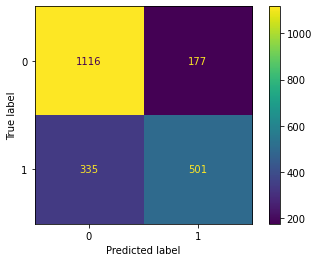

In [120]:
# define X and y, train-test split
nlp = fl[['agg_charges', 'recidivism']].dropna()
X = nlp['agg_charges']
y = nlp['recidivism']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# Pipeline with logreg
pipe = Pipeline(steps = [('tfidf', TfidfVectorizer()), ('logreg', LogisticRegression(max_iter = 10_000))])

pipe_params = {
    'tfidf__stop_words': [None, 'english'],
    'tfidf__max_features': [3000, 4000],
    'tfidf__min_df': [1, 2],
    'tfidf__max_df': [0.8, 0.9],
    'tfidf__ngram_range': [(1, 1), (1, 2)]
}

model_trials('FL', X, y, pipe, 'TFIDF + Logreg', gs_params = pipe_params);

ANALYSIS
- Really pretty surprising result - using ONLY the NLP columns resulted in almost 0.76 accuracy on the testing set, with minimal overfitting
- Specificity is not bad either at 0.86
- Now we'll try combining these columns with our existing dataset to see if they enhance the outcome

In [121]:
# what were our best parameters?
model_trials_df[model_trials_df['dataset_name'] == 'FL']['model_params'].values

array([{'tfidf__max_df': 0.8, 'tfidf__max_features': 3000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}],
      dtype=object)

In [122]:
# now we can apply our optimal vectorization
tfidf = TfidfVectorizer(max_df = 0.8, max_features = 3000, min_df = 1, ngram_range = (1, 2))
nlpcols = tfidf.fit_transform(fl['agg_charges'])

In [123]:
# and add the vectorized columns to our main dataframe
fl_nlp = pd.concat([fl, pd.DataFrame(nlpcols.todense(), columns = tfidf.get_feature_names_out())], axis = 1)

In [124]:
# define our final X and y
X = fl_nlp.drop(columns = ['recidivism', 'agg_charges'])
y = fl_nlp['recidivism']

Dataset: FL
Model ID: nlp_gboost
Model Params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 150, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Training Score: 0.8976
Testing Score: 0.884 

Accuracy: 0.884
Specificity: 0.8623
Precision: 0.8116
Recall: 0.9175
F1 Score: 0.8613 

Best accuracy rate confusion matrix:


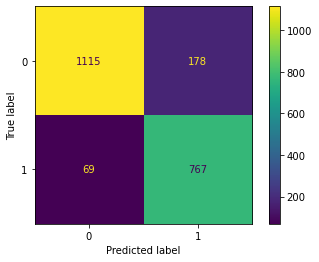

In [125]:
# Let's try using our selected favorite for the FL dataset, which was GradientBoost
# parameters copied from modeling notebook
nlp_gboost = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, min_samples_leaf = 1, min_samples_split = 2,
    n_estimators = 150, subsample = 1.0)
model_trials('FL', X, y, nlp_gboost, 'nlp_gboost');

ANALYSIS

- Looks like adding the NLP columns to the production model does actually provide a tiny increase in test accuracy - less than 0.003 increase, but still an increase
- However, the specificity has taken about an 0.01 hit, which doesn't seem like a worthwhile tradeoff
- We won't use the NLP columns for now in our production model - interesting experiment though!
- We will capture the "top 10" bigrams according to TFIDF as a point of interest for presentation

In [126]:
# top 10 bigrams
X[[col for col in X if len(col.split()) == 2]].sum().sort_values(ascending = False)[:10]

possession of        311.705296
fail to              298.592501
license suspended    297.175436
grand theft          290.510691
in the               262.923713
theft in             259.942000
3rd degree           258.306656
the 3rd              258.305982
or less              253.256884
possess cannabis     252.842420
dtype: float64

---
**Model 3 Experiment: Behavioral feature set - Georgia - focus on important features**

- We're going build a model using only the most important features identified during the model trials, in the hopes reducing some of the noise and improving our accuracy.

In [127]:
# Reading in necessary files
ga_dummy = pd.read_csv('../data/GA/georgia_dummy.csv')
feats = pd.read_csv('../data/GA/important_feats.csv')

In [128]:
# Merging dataframes to include only the important features and target column

important_feats = feats.loc[(feats['coef'] > 1.15) | (feats['coef'] < 0.85)]

important_cols = [col for col in important_feats['feature']]

ga_exper = ga_dummy[important_cols]
ga_exper = ga_exper.join(ga_dummy['recidivism_within_3years'])
ga_exper

,gang_affiliated,age_at_release_18-22,age_at_release_23-27,gender_male,condition_mh_sa,drugtests_thc_positive,violations_instruction,violations_electronicmonitoring,prison_years_more than 3 years,education_level_less than hs diploma,age_at_release_38-42,education_level_at least some college,prison_years_greater than 2 to 3 years,age_at_release_43-47,age_at_release_48 or older,percent_days_employed,recidivism_within_3years
0,0,0,0,1,1,0.000000,0,0,1,0,0,1,0,1,0,0.488562,0
1,0,0,0,1,0,0.000000,1,0,1,1,0,0,0,0,0,0.425234,1
2,0,0,0,1,1,0.333333,1,0,0,0,0,1,0,0,1,0.000000,1
3,0,0,0,1,1,0.000000,0,0,0,1,1,0,0,0,0,1.000000,0
4,0,0,0,1,1,0.000000,0,0,0,1,0,0,0,0,0,0.203562,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24421,0,0,1,1,0,0.000000,0,0,1,0,0,1,0,0,0,0.189507,1
24422,0,0,0,1,0,0.000000,0,0,1,0,1,1,0,0,0,0.757098,1
24423,0,0,0,1,0,0.000000,0,1,1,0,0,1,0,0,0,0.711138,1
24424,0,0,0,0,0,0.000000,0,0,1,0,0,1,0,0,0,0.000000,0


In [129]:
# setup X and y
X = ga_exper.drop(columns='recidivism_within_3years')
y = ga_exper['recidivism_within_3years']

Dataset: GA
Model ID: imp_grad
Model Params: {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
Training Score: 0.6941
Testing Score: 0.6871 

Accuracy: 0.6871
Specificity: 0.5431
Precision: 0.7173
Recall: 0.7845
F1 Score: 0.7494 

Best accuracy rate confusion matrix:


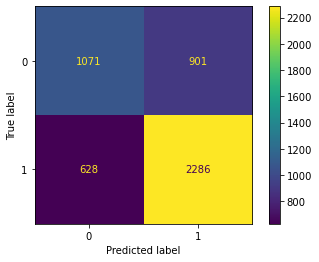

In [130]:
gb = GradientBoostingClassifier()

model_trials('GA', X, y, gb, 'imp_grad');

Dataset: GA
Model ID: imp_logreg
Model Params: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Training Score: 0.6799
Testing Score: 0.6736 

Accuracy: 0.6736
Specificity: 0.4944
Precision: 0.6991
Recall: 0.7948
F1 Score: 0.7439 

Best accuracy rate confusion matrix:


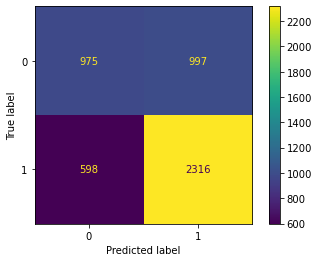

In [131]:
lr = LogisticRegression()

model_trials('GA', X, y, lr, 'imp_logreg');

Dataset: GA
Model ID: imp_knn
Model Params: {'memory': None, 'steps': [('ss', StandardScaler()), ('knn', KNeighborsClassifier())], 'verbose': False, 'ss': StandardScaler(), 'knn': KNeighborsClassifier(), 'ss__copy': True, 'ss__with_mean': True, 'ss__with_std': True, 'knn__algorithm': 'auto', 'knn__leaf_size': 30, 'knn__metric': 'minkowski', 'knn__metric_params': None, 'knn__n_jobs': None, 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'}
Training Score: 0.7167
Testing Score: 0.6269 

Accuracy: 0.6269
Specificity: 0.502
Precision: 0.6786
Recall: 0.7114
F1 Score: 0.6946 

Best accuracy rate confusion matrix:


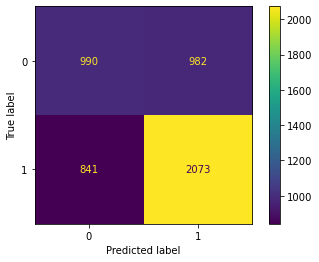

In [132]:
knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

model_trials('GA', X, y, knn, 'imp_knn');

Dataset: GA
Model ID: imp_rf
Model Params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Training Score: 0.879
Testing Score: 0.6443 

Accuracy: 0.6443
Specificity: 0.4888
Precision: 0.6842
Recall: 0.7495
F1 Score: 0.7154 

Best accuracy rate confusion matrix:


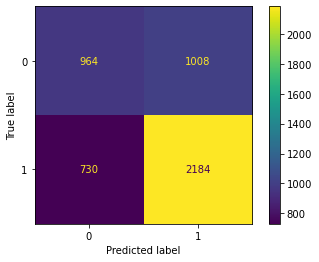

In [133]:
rf = RandomForestClassifier()

model_trials('GA', X, y, rf, 'imp_rf');

Dataset: GA
Model ID: imp_ada
Model Params: {'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None}
Training Score: 0.6875
Testing Score: 0.6871 

Accuracy: 0.6871
Specificity: 0.5106
Precision: 0.7089
Recall: 0.8065
F1 Score: 0.7545 

Best accuracy rate confusion matrix:


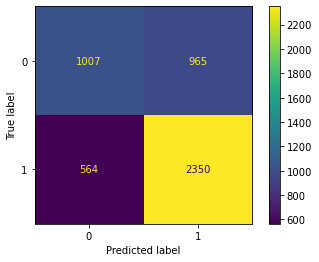

In [134]:
ada = AdaBoostClassifier()

model_trials('GA', X, y, ada, 'imp_ada');

Dataset: GA
Model ID: imp_mnb
Model Params: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
Training Score: 0.6523
Testing Score: 0.6472 

Accuracy: 0.6472
Specificity: 0.4077
Precision: 0.6687
Recall: 0.8092
F1 Score: 0.7323 

Best accuracy rate confusion matrix:


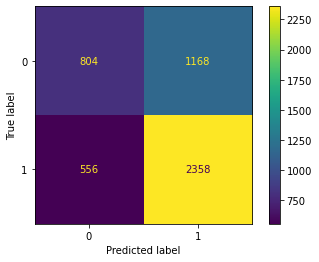

In [135]:
mnb = MultinomialNB()

model_trials('GA', X, y, mnb, 'imp_mnb');

Dataset: GA
Model ID: imp_bag
Model Params: {'base_estimator': None, 'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Training Score: 0.8651
Testing Score: 0.6302 

Accuracy: 0.6302
Specificity: 0.5223
Precision: 0.6851
Recall: 0.7032
F1 Score: 0.694 

Best accuracy rate confusion matrix:


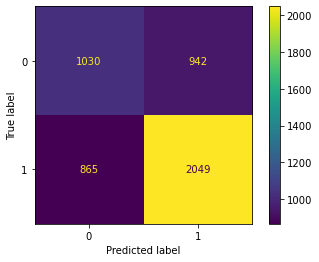

In [136]:
bag = BaggingClassifier()

model_trials('GA', X, y, bag, 'imp_bag');

Dataset: GA
Model ID: imp_dtree
Model Params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Training Score: 0.8794
Testing Score: 0.6142 

Accuracy: 0.6142
Specificity: 0.5304
Precision: 0.6786
Recall: 0.6709
F1 Score: 0.6747 

Best accuracy rate confusion matrix:


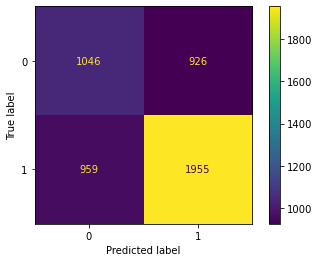

In [137]:
dtree = DecisionTreeClassifier()

model_trials('GA', X, y, dtree, 'imp_dtree');

In [138]:
# Let's compare results
model_trials_df[model_trials_df['dataset_name'] == 'GA'].sort_values(by='accuracy', ascending = False).head(10)

,dataset_name,model_used,model_params,train_score,test_score,accuracy,specificity,precision,recall,f1 score,true_neg,false_pos,false_neg,true_pos
2,GA,imp_grad,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.694063,0.687065,0.687065,0.543103,0.717289,0.784489,0.749385,1071,901,628,2286
6,GA,imp_ada,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.687462,0.687065,0.687065,0.510649,0.708899,0.806452,0.754535,1007,965,564,2350
3,GA,imp_logreg,"{'C': 1.0, 'class_weight': None, 'dual': False...",0.679887,0.673557,0.673557,0.494422,0.699064,0.794784,0.743857,975,997,598,2316
7,GA,imp_mnb,"{'alpha': 1.0, 'class_prior': None, 'fit_prior...",0.652303,0.647155,0.647155,0.407708,0.668746,0.809197,0.732298,804,1168,556,2358
5,GA,imp_rf,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.879017,0.644290,0.644290,0.488844,0.684211,0.749485,0.715362,964,1008,730,2184
8,GA,imp_bag,"{'base_estimator': None, 'bootstrap': True, 'b...",0.865097,0.630168,0.630168,0.522312,0.685055,0.703157,0.693988,1030,942,865,2049
4,GA,imp_knn,"{'memory': None, 'steps': [('ss', StandardScal...",0.716735,0.626893,0.626893,0.502028,0.678560,0.711393,0.694589,990,982,841,2073
9,GA,imp_dtree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.879376,0.614204,0.614204,0.530426,0.678584,0.670899,0.674720,1046,926,959,1955


ANALYSIS

- Removing all features except those that scored highest on importance seems to have lessened their importance.
- All models aside from MNB scored worse on accuracy.
- We're seeing jumps in both types of misclassifications for all models tested.
- Overall, it appears that keeping the less important features in the model helps it weigh the variables more accurately and correctly predict recidivism more often.

---
**FINAL NOTES**
- There is no output from this notebook.
- The last notebook in the series is [Results and Recommendations](./04_results.ipynb).